# First, load xslx file as an AnnData object

In [6]:


import os, sys
import numpy as np
import pandas as pd
import anndata

filepath = '/home/dolley/gear/tests/base_template.xlsx'

#Read in each sheet of xlsx
exp_df = pd.read_excel(filepath, sheet_name='expression', index_col=0).transpose()
obs_df = pd.read_excel(filepath, sheet_name='observations', index_col='observations')
genes_df = pd.read_excel(filepath, sheet_name='genes', index_col='genes')

#keep only expression values
X = exp_df.values[:, 0:].astype(float)

#create AnnData object
adata = anndata.AnnData(X=X, obs=obs_df, var=genes_df)

                                       0          1          2          3   \
cell_type condition time_point                                               
utricle   control   0           71.666667  53.333333  49.666667  67.000000   
                    24          26.333333  42.000000  66.333333  40.000000   
                    48          65.666667  61.333333  36.666667  66.333333   
          treated   0           46.666667  77.000000  54.666667  32.333333   
                    24          53.000000  42.333333  22.666667  32.000000   
                    48          48.666667  34.333333  50.666667  51.333333   

                                       4          5          6          7   \
cell_type condition time_point                                               
utricle   control   0           63.333333  10.333333  26.333333  55.000000   
                    24          34.000000  44.333333  48.666667  46.666667   
                    48          43.333333  57.000000  63.666667

# Calculate mean, standard deviation, & standard error of the mean (uses Alex Wolf's logic)

In [7]:
obs = adata.obs

#Prep expression expression for stat calculations
df = pd.DataFrame(X)  # does not allocate new memory if X is an array, so this efficient
df['cell_type'] = obs['cell_type'].values  # if not using assign, no copy is made
df['condition'] = obs['condition'].values  # if not using assign, no copy is made
df['time_point'] = obs['time_point'].values  # if not using assign, no copy is made
df_grouped = df.groupby(['cell_type', 'condition', 'time_point'])

#Calculate Mean, Standard Deviation and Standard Error of the Mean
# add resultant dataframes to adata object
adata.Xmean = df_grouped.mean()
adata.Xstd = df_grouped.std()
adata.Xsem = df_grouped.sem()

print(adata.Xmean)
print(adata.Xstd)
print(adata.Xsem)

                                       0          1          2          3   \
cell_type condition time_point                                               
utricle   control   0           71.666667  53.333333  49.666667  67.000000   
                    24          26.333333  42.000000  66.333333  40.000000   
                    48          65.666667  61.333333  36.666667  66.333333   
          treated   0           46.666667  77.000000  54.666667  32.333333   
                    24          53.000000  42.333333  22.666667  32.000000   
                    48          48.666667  34.333333  50.666667  51.333333   

                                       4          5          6          7   \
cell_type condition time_point                                               
utricle   control   0           63.333333  10.333333  26.333333  55.000000   
                    24          34.000000  44.333333  48.666667  46.666667   
                    48          43.333333  57.000000  63.666667

# Simulate user searching for gene and plot as a bar graph 

In [51]:
#Gene symbol to search
searched_gene = "Gnai3"

#Find the gene's index position (integer)
var = adata.var
var_index = pd.Index(var.index)
gene_index_label = var.index[var['gene_symbol'] == searched_gene].tolist()[0] #Get 1st found
gene_index = var_index.get_loc(gene_index_label) #Get the index label's position in the index

gene_index 

0

In [133]:
# Get mean expressions for the gene
expression_means = adata.Xmean.iloc[:,gene_index]
df_means = pd.DataFrame(expression_means.values)
print(expression_means)

# Get std 
df_std = adata.Xstd.iloc[:,gene_index]

# add x-axis tick labels
condition_tuples = df_std.index.tolist()

x_ticks = list()
for (cell_type, condition, time_point) in condition_tuples:
    x_ticks.append(cell_type + " " + condition + " " + str(time_point))

cell_type  condition  time_point
utricle    control    0             71.666667
                      24            26.333333
                      48            65.666667
           treated    0             46.666667
                      24            53.000000
                      48            48.666667
Name: 0, dtype: float64


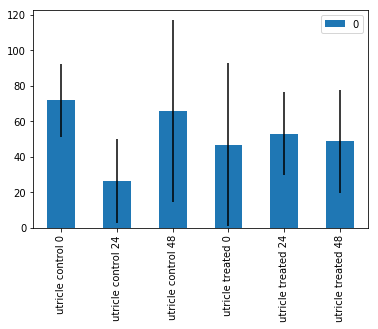

In [134]:
#Plot means with standard dev and add xtick labels
ax = df_means.plot.bar(yerr=df_std.values)
ax.set_xticklabels(x_ticks)

# Problem with this plot is the ordering. Bars are not grouped like gEAR

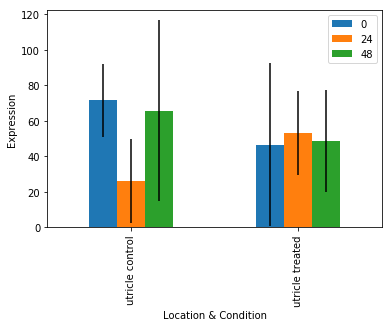

In [210]:
#TRY TO SORT TO MATCH gEAR LAYOUT
# Get mean expressions for the gene
expression_means = pd.DataFrame(adata.Xmean.iloc[:,gene_index])

# Get std 
expression_stds = pd.DataFrame(adata.Xstd.iloc[:,gene_index])

# print(expression_means.values)
# print(expression_stds.values)

# Get time point label for each bar
conditions_per_grouping = expression_means.index.levels[1].size
bar_labels = expression_means.unstack().columns.levels[1].tolist()# * conditions_per_grouping
# print(bar_labels)

# add x-axis tick labels
condition_tuples = expression_means.unstack().index.tolist()

x_ticks = list()
for (cell_type, condition) in condition_tuples:
    x_ticks.append(cell_type + " " + condition)

# Combo of these 2 links herlped to get me the following plot
# https://stackoverflow.com/a/13876784/2900840
# https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html

ax = expression_means.unstack().plot(kind='bar', yerr=expression_stds.unstack())
ax.legend(labels=bar_labels)
ax.set_xticklabels(x_ticks)
ax.set_ylabel("Expression")
ax.set_xlabel("Location & Condition")